# 99 - Fermionic QAOA (FQAOA)

This notebook provides a brief introduction to Fermionic QAOA (FQAOA). 
It shows how this technique is implemented in the OpenQAOA workflow by solving the constrained quadratic optimization problem, an NP-hard problem.

## A brief introduction

We present an implementation of a novel algorithm designed for solving combinatorial optimization problems with constraints, utilizing the principles of quantum computing. The algorithm, known as the FQAOA [1, 2], introduces a significant enhancement over traditional methods by leveraging fermion particle number preservation. This intrinsic property allows the algorithm to enforce constraints naturally throughout the optimization process, addressing a critical challenge in many combinatorial problems.

### Key Features
- Constraint Handling: In contrast to conventional approaches, which treat constraints as soft constraints in the cost function, FQAOA enforces constraints intrinsically by preserving fermion particle numbers, thereby enhancing the overall performance of the optimization algorithm.

- Design of FQAOA Ansatz: In this algorithm,
the mixer is designed so that any classical state can be reached by its multiple actions.
The initial state is set to a ground state of the mixer Hamiltonian satisfying the constraints of the problem.

- Adiabatic Evolution: FQAOA effectively reduces to quantum adiabatic computation in the large limit of circuit depth, $p$, offering improved performance even for shallow circuits by optimizing parameters starting from fixed angles determined by Trotterized quantum adiabatic evolution.

- Performance Advantage: Extensive numerical simulations demonstrate that FQAOA offers substantial performance benefits over existing methods, particularly in portfolio optimization problems.

- Broad Applicability: The Hamiltonian design guideline benefits QAOA and extends to other algorithms like Grover adaptive search and quantum phase estimation, making it a versatile tool for solving constrained combinatorial optimization problems.

This notebook describes the implementation of FQAOA, illustrates its application through various examples, and provides insight into FQAOA's superior performance in constrained combinatorial optimization tasks.

### Constrained Combinatorial Optimization Problems and Cost Hamiltonian
The constrained combinatorial optimization problem for a polynomial cost function　$C_{\boldsymbol x}$ covered here can be written in the following form：
$${\boldsymbol x}^* = \arg \min_{\boldsymbol x} C_{\boldsymbol x}\qquad {\rm s.t.} \quad\sum_{i=1}^{N} x_i = M,$$
with bit string ${\boldsymbol x}\in \{0,1\}^N$, where ${\boldsymbol x}^*$ is the optimal solution.
This problem can be replaced by the minimum eigenvalue problem in the following steps.

1. map the cost function $C_{\boldsymbol x}$ to the cost Hamiltonian $\hat{\cal H}_C$ by $x_i\rightarrow \hat{n}_i$:
\begin{eqnarray}
C_{\boldsymbol x} &=& \sum_i I_i x_{i}+\sum_{i_1,i_2} I_{i_1,i_2} x_{i_1}x_{i_2}+\cdots +
\sum_{i_1,i_2,\cdots i_K} I_{i_1,i_2,\cdots i_K} x_{i_1}x_{i_2}\cdots x_{i_K}\\
&\mapsto&\hat{\cal H}_C=\sum_i I_i \hat{n}_{i}+\sum_{i_1,i_2} I_{i_1,i_2} \hat{n}_{i_1}\hat{n}_{i_2}+\cdots +
\sum_{i_1,i_2,\cdots i_K} I_{i_1,i_2,\cdots i_K} \hat{n}_{i_1}\hat{n}_{i_2}\cdots \hat{n}_{i_K},
\end{eqnarray}
where $\hat{n}_i = \hat{c}^\dagger_i\hat{c}_i$ is number operator and $\hat{c}_i^\dagger (\hat{c}_i)$ is creation (annihilation) operator of fermion at $i$-th site.

2. formulate eigen value problems for combinatorial optimization problem under the constraint:
\begin{eqnarray}
\hat{\cal H}_C|x_1x_2\cdots x_N\rangle &=& C_{\boldsymbol x}|x_1x_2\cdots x_N\rangle,\\
\sum_{i=1}^{N} \hat{n}_i|x_1x_2\cdots x_N\rangle &=& M|x_1x_2\cdots x_N\rangle,
\end{eqnarray}
where $|x_1x_2\cdots x_N\rangle=(\hat{c}^\dagger_1)^{x_1}(\hat{c}^\dagger_2)^{x_2}\cdots (\hat{c}^\dagger_N)^{x_N}|{\rm vac}\rangle$ is fermionic basis state and $|\rm vac\rangle$ is vacuum satisfying $\hat{c}_i|\rm vac\rangle=0$.

3. optimize FQAOA ansatz:
$$|\psi_p({\boldsymbol \gamma}^*, {\boldsymbol \beta}^*)\rangle 
= \left[\prod_{j=1}^pU(\hat{\cal H}_M,\beta_j^*){U}(\hat{\cal H}_C,\gamma_j^*)\right]\hat{U}_{\rm init}|{\rm vac}\rangle
\qquad {\rm by}\quad
C_p({\boldsymbol \gamma}^*, {\boldsymbol \beta}^*)=\min_{{\boldsymbol \gamma}, {\boldsymbol \beta}}C_p({\boldsymbol \gamma},{\boldsymbol \beta}),$$
$$\qquad{\rm where \quad}C_p({\boldsymbol \gamma}, {\boldsymbol \beta}) = \langle\psi_p({\boldsymbol \gamma}, {\boldsymbol \beta})|\hat{\cal H}_C|\psi_p({\boldsymbol \gamma}, {\boldsymbol \beta})\rangle.$$
The variational parameters $({\boldsymbol \gamma}^*, {\boldsymbol \beta}^*)$ give the lowest cost value at QAOA level $p$.


### One-Dimensional Mixer Hamiltonian

The FQAOA implemented on OpenQAOA employs mixer Hamiltonians on one-dimensional lattices. The main features of this computational model are summarized based on the study [2]:

- Utilises a mixer Hamiltonian on a one-dimensional lattice dedicated to combinatorial optimization problems with equality constraints of the same coefficients.

- Reduced Gate Operations: The new mixer Hamiltonian significantly reduces the number of gate operations in quantum circuits compared to previous studies [1], thus improving computational efficiency.

- Noise suppression: as demonstrated in a 16-qubit trapped-ion quantum computer on Amazon Braket, the proposed mixer Hamiltonian effectively suppresses noise and improves algorithm performance.

As these features enhance the performance and reliability of FQAOA for solving constrained combinatorial optimization problems, we focus on FQAOA with one-dimensional mixer hamiltonians.

The specific mixer Hamiltonian $\hat{\cal H}_M$ on cyclic lattice to be implemented in OpenQAOA are as follow:

\begin{eqnarray}
\hat{\cal H}_M &=& t\sum_{i=1}^{N-1} (\hat{c}^\dagger_i\hat{c}_{i+1}+\hat{c}^\dagger_{i+1}\hat{c}_i)-t(-1)^{M}(\hat{c}^\dagger_N\hat{c}_{1}+\hat{c}^\dagger_{1}\hat{c}_N).
\end{eqnarray}
These Hamiltonians can be diagonalized as:
$$\hat{\cal H}_M=\sum_{i=1}^{N}\varepsilon_i\hat{\gamma}_i^\dagger\hat{\gamma}_i \qquad {\rm with} \quad
\hat{\gamma}_i^\dagger = \sum_{j=1}^N[\phi_0]_{i,j}\hat{c}^\dagger_j,$$
where $[\phi_0]$ is the unitary matrix used for the diagonalization and $\varepsilon_i$ is eigenvalue.
The formulation and validation of the model on cyclic lattice are detailed in the study [2].

### Initial State and Mixer for FQAOA

We describe the specific calculation model utilized for our implementation of the FQAOA on cyclic lattice. 
The initial state preparation unitary $\hat{U}_{\rm init}$ and the mixer $\hat{U}_M$ used to implement the FQAOA are shown below.

- initial state preparation unitary $\hat{U}_{\rm init}$ on cyclic lattice:
$$|\phi_0\rangle=\hat{U}_{\rm init}|{\rm vac}\rangle=\left(\prod_{i=1}^{M}\hat{\gamma}_i^\dagger\right)|{\rm vac}\rangle,
\qquad{\rm with}\quad \hat{U}_{\rm init}=\prod_{i=1}^{M}\left(\sum_{j=1}^N[\phi_0]_{i,j}\hat{c}^\dagger_j\right),$$
where $M$ is the number of fermions and $i$ indexes the eigenvalues $\varepsilon_i$ in ascending order.
The implementation of the initial state preparation unitary on quantum circuit are shown in Refs. [1-3].

- mixing unitary $U(\hat{\cal H}_M, \beta)$ on cyclic lattice:
\begin{eqnarray}
U(\hat{\cal H}_M, \beta) &\sim&
\exp\left[i\beta t(-1)^M\left(\hat{c}^{\dagger}_{ND}\hat{c}_{1}+\hat{c}^{\dagger}_{1}\hat{c}_{ND}\right)\right]
\prod_{i\ {\rm even}}\exp\left[-i\beta t\left(\hat{c}^{\dagger}_i\hat{c}_{i+1}+\hat{c}^{\dagger}_{i+1}\hat{c}_{i}\right)\right]
\prod_{i\ {\rm odd}}\exp\left[-i\beta t\left(\hat{c}^{\dagger}_i\hat{c}_{i+1}+\hat{c}^{\dagger}_{i+1}\hat{c}_{i}\right)\right],
\end{eqnarray}
where the approximation by Trotter decomposition is applied, as certain hopping terms are non-commutative.
The implementation of the mixed unitary indicated on the right-hand side on quantum circuits is given in Refs. [1, 2, 4, 5].

## Constrained Quadratic Optimization Problem

The objective function of the constrined optimization problem is given by 

$$\min_{x} : q x^{T} \Sigma x-\mu^{T} x,\qquad {\rm s.t.} \quad\sum_{i=1}^{N} x_i = M,$$

where:
- $N$: number of decision variables
- $x \in\{0,1\}^{N}$: vector of binary decision variables,
- $\mu \in R^{n}$: vector of coefficients for the linear term,
- $\Sigma \in R^{n \times n}$: symmetric positive semidefinite matrix for quadratic term,
- $q$: quadratic term coeffient,
- $M$: constraint on the sum of decision variables.

In the following, the [portfolio optimization problem](https://en.wikipedia.org/wiki/Portfolio_optimization) is taken as a constrained quadratic formal optimisation problem. The same model parameters are used as in [6].

In [1]:
import numpy as np
# Init variables to geretate the data for portfolio optimization
np.random.seed(1)
num_assets = 10
num_days = 15
q = 1.0
Budget = 5
hist_exp = (1 - 2 * np.random.rand(num_assets)).reshape(-1,1) * (np.array([np.arange(num_days) for i in range(num_assets)]) + np.random.randint(10)) + (1 - 2 * np.random.rand(num_assets,  num_days)) 
# Mean expected return and covriance matrix
mu = hist_exp.mean(axis=1)
sigma = np.cov(hist_exp) 

In [2]:
from docplex.mp.model import Model
from openqaoa.problems.converters import FromDocplex2IsingModel

# portfolio optimization function
mdl = Model()
x = np.array(mdl.binary_var_list(num_assets)) 
objective_function = q * (x.T @ sigma @ x) - mu @ x
mdl.minimize(objective_function)
mdl.add_constraint(x.sum() == Budget)
qubo_po = FromDocplex2IsingModel(mdl)
ising_encoding_po = qubo_po.ising_model 

##  Solving problems using FQAOA on OpenQAOA

In [3]:
# Indicate the device, this case is a local simulator
from openqaoa.backends import create_device
device = create_device('local', 'qiskit.statevector_simulator')

The quantum algorithms consider the following properties: the qiskit's statevector_simulator backend with a `p` value equals to 2, with `ramp` initialization.

### Optimization using FQAOA

Here, a fermionic mixer Hamiltonian $\hat{\cal H}_M$ on cyclic lattice determines its ground state as the initial state $\hat{U}_{\rm init}|\rm vac\rangle$ and its mixer $U(\hat{\cal H}_M, \beta)$.

In [4]:
from openqaoa import FQAOA
fqaoa = FQAOA(device)
fqaoa.set_fqaoa_parameters(n_qubits=num_assets, n_fermions=Budget)
fqaoa.set_circuit_properties(p=2, init_type='ramp')
fqaoa.compile(ising_encoding_po)
fqaoa.optimize()
fqaoa_results = fqaoa.result

### Optimization using Conventional QAOA

Here, the conventional X-mixer Hamiltonian $H_M$ determines its ground state as the initial state and its unitary transformation $\exp(-i\beta\hat{\cal H}_M)$ as the mixer.

In [5]:
from openqaoa import QAOA
qaoa = QAOA(device)
qaoa.set_circuit_properties(p=2, init_type='ramp')
qaoa.compile(ising_encoding_po)
qaoa.optimize()
qaoa_results = qaoa.result

### Performance Evaluation of FQAOA

To evalueate the performance of FQAOA, we show expectation value of costs. 
We define normalized costs by 
$\Delta C/W$ with $\Delta C = (cost-cost_{\rm min})$ and $W=(cost_{\rm max}-cost_{\rm min})$, where $cost_{\rm max}$ ($cost_{\rm min}$) is maximum (minimum) value of cost under the cosntraint.

In [6]:
# maximum-minimum estimations of costs for normalization
from openqaoa.utilities import bitstring_energy
qaoa_po = QAOA(device)
qaoa_po.compile(ising_encoding_po)
x_in_constraint = []
for i in range(2**num_assets):
    bit = bin(i)[2:].zfill(num_assets)
    cost = bitstring_energy(qaoa_po.cost_hamil, bit[::-1])
    if bit.count('1') == Budget:
        x_in_constraint.append(cost)
max_x, min_x = max(x_in_constraint), min(x_in_constraint)
print('(cost_min, cost_max) = ', '(', min_x, max_x,')')

(cost_min, cost_max) =  ( -2.6042725099164272 210.7614169508679 )


In [7]:
# optimization
label_list = ['QAOA', 'FQAOA']
opt_results_list, cost_list = [], []
exp_cost_dict = {}
for opt_result in [qaoa_results, fqaoa_results]:
    opt_results_list.append(opt_result)
    cost_list.append(opt_result.optimized['cost'])

In [8]:
import pandas as pd
exp_cost_dict['method'] = label_list
exp_cost_dict['cost'] = cost_list
exp_cost_dict[r'$\Delta C$/W'] = (np.array(cost_list)-min_x)/(max_x-min_x)
df = pd.DataFrame(exp_cost_dict)
display(df)

,method,cost,$\Delta C$/W
0,QAOA,1294.838616,6.080841
1,FQAOA,27.028662,0.138883


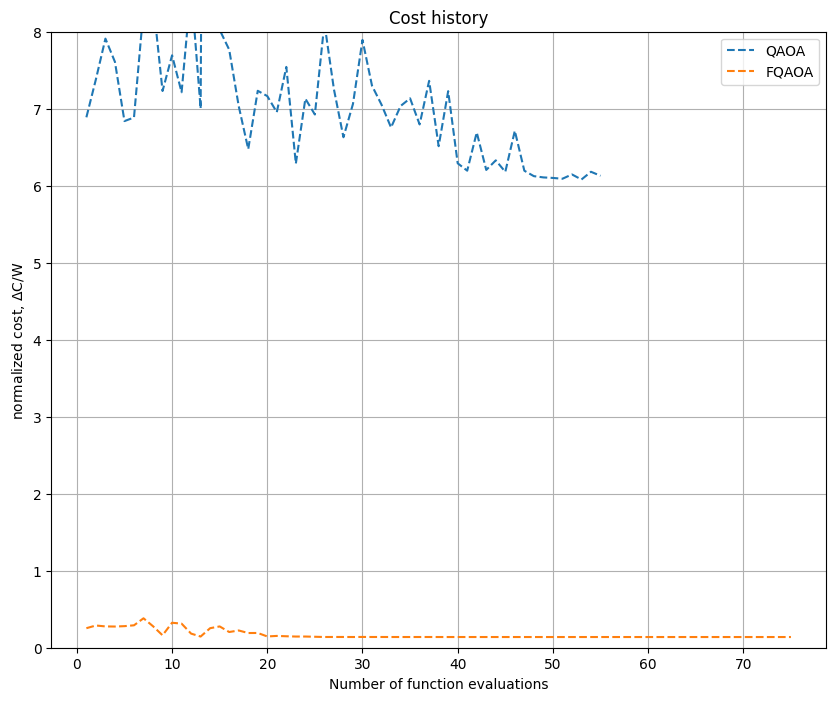

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot cost history
figsize=(10, 8)
fig, ax = plt.subplots(figsize=figsize)
x3values, y3values = [], []
for i, opt_results in enumerate(opt_results_list):
    # print the cost history
    opt_results.plot_cost(ax = ax, color = f'C{i}', label = label_list[i])
ax.grid(True)    
ax.set_ylim(min_x, 2000)
ylim_scaled = 8
ax.set_ylabel(r'normalized cost, $\Delta$C/W')
ax.set_ylim(min_x, min_x+(ylim_scaled)*(max_x-min_x))
ax.set_yticks([min_x+i*(max_x-min_x) for i in range(ylim_scaled+1)], [i for i in range(ylim_scaled+1)])

plt.show()

### Performance Evaluation of FQAOA

show the best 5 states for this particular Portfolio optimization problem

In [10]:
# Print the best 5 solutions
lowest_dict = opt_results_list[0].lowest_cost_bitstrings(5)
#list1 = qaoa_po_dict['bitstrings_energies']
list1 = lowest_dict['bitstrings_energies']
list2 = [(list1[i]-min_x)/(max_x-min_x) for i in range(5)]
qaoa_po_dict = {}
qaoa_po_dict['solutions bitstrings'] = lowest_dict['solutions_bitstrings']
qaoa_po_dict['cost'] = lowest_dict['bitstrings_energies']
qaoa_po_dict[r'$\Delta$C/W'] = [(list1[i]-min_x)/(max_x-min_x) for i in range(5)]
qaoa_po_dict[f'Probability ({label_list[0]})'] = lowest_dict.pop('probabilities')
qaoa_po_dict[f'Probability ({label_list[1]})'] = opt_results_list[1].lowest_cost_bitstrings(5)['probabilities']
df = pd.DataFrame(qaoa_po_dict)
print('Comparison of methods for calculating the probability of finding the optimal solutions')
display(df)

Comparison of methods for calculating the probability of finding the optimal solutions


,solutions bitstrings,cost,$\Delta$C/W,Probability (QAOA),Probability (FQAOA)
0,1101100001,-2.604273,0.000000,0.000034,0.009313
1,1101000101,-2.472965,0.000615,0.000092,0.018148
2,1101001001,-2.299722,0.001427,0.000001,0.012510
3,1100100101,-2.160815,0.002078,0.000006,0.004845
4,1100100011,-1.820697,0.003672,0.000069,0.012701


show the probability distribution of costs.

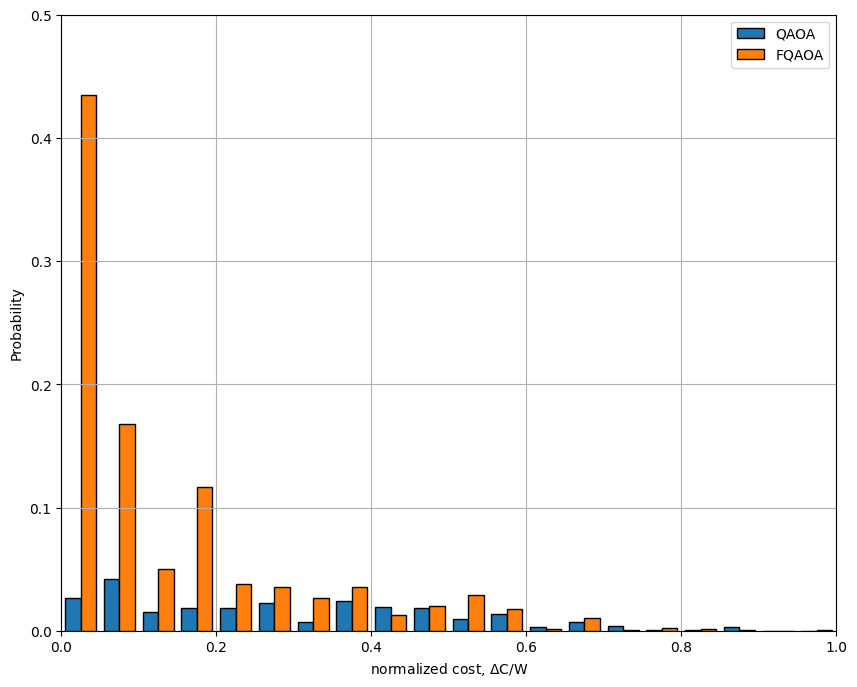

In [11]:
# plot energy distribution
xvalues, yvalues = [], []
for opt_results in opt_results_list:
    measurement_outcomes = opt_results.optimized['measurement_outcomes']
    costprob = []
    for i, amplitude in enumerate(measurement_outcomes):
        bit = bin(i)[2:].zfill(num_assets)
        probability = abs(amplitude)**2
        costprob.append([bitstring_energy(qaoa_po.cost_hamil, bit[::-1]), probability, bit])

    # Extracting the second values from the data points for the histogram
    xvalues.append([(point[0]-min_x)/(max_x-min_x) for point in costprob])
    yvalues.append([point[1] for point in costprob])

xmax, bins = 1.0, 20
figsize=(10, 8)
fig, ax = plt.subplots(figsize=figsize)
ax.set_xlim(0, xmax)
ax.set_ylim(0, 0.5)
ax.hist(xvalues, bins = np.linspace(0, xmax, bins+1), weights=yvalues, edgecolor='black', label = label_list)
ax.set_xlabel(r'normalized cost, $\Delta$C/W')
ax.set_ylabel('Probability')
ax.grid(True)
ax.legend()

plt.show()

# References

[1] T. Yoshioka, K. Sasada, Y. Nakano, and K. Fujii, [Phys. Rev. Research 5, 023071 (2023).](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.5.023071), [arXiv: 2301.10756 [quant-ph]](https://arxiv.org/pdf/2301.10756). \
[2] T. Yoshioka, K. Sasada, Y. Nakano, and K. Fujii, [2023 IEEE International Conference on Quantum Computing and Engineering (QCE) 1, 300-306 (2023).](https://ieeexplore.ieee.org/document/10313662), [arXiv: 2312.04710 [quant-phi]](https://arxiv.org/pdf/2312.04710). \
[3] Z. Jiang, J. S. Kevin, K. Kechedzhi, V. N. Smelyanskiy, and S. Boixo, [Phys. Rev. Appl. 9, 044036 (2018).](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.9.044036) \
[4] S. Hadfield, Z. Wang, B. O’Gorman, E. G. Rieffel, D. Venturelli, and R. Biswas, [algorithms 12, 34 (2019).](https://www.mdpi.com/1999-4893/12/2/34) \
[5] Z. Wang, N. C. Rubin, J. M. Dominy, and E. G. Rioeffel, [Phys. Rev. A 101, 012320 (2020).](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.012320) \
[6] [openqaoa/examples/community_tutorials/03_portfolio_optimization.ipynb](https://github.com/entropicalabs/openqaoa/blob/main/examples/community_tutorials/03_portfolio_optimization.ipynb)